# SEED 1

In [1]:
import numpy as np
from six.moves import urllib
import os
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
DATA_DIRECTORY = "./seed_python"
SOURCE_URL = 'http://35.183.27.27/'

def maybe_download(filename):
    """Download the data, unless it's already here."""
#    if not os.path.exists(DATA_DIRECTORY):
#        tf.io.gfile.MakeDirs(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)
    #if not os.path.exists(filepath):
    #    print('please change DATA_DIRECTORY to data dir, no file found')
    #    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    #    with tf.io.gfile.GFile(filepath) as f:
    #        size = f.size()
    #    print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

def dense_to_one_hot(labels_dense, num_classes = 3):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def load_data(filename, one_hot=False):
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        data = dict['data']
        labels = dict['label']

        if one_hot:
            labels = dense_to_one_hot(labels)
        return data, labels

class DataSet(object):
    def __init__(self, data, labels):
        assert data.shape[0] == labels.shape[0], ("data.shape: %s labels.shape: %s" % (data.shape, labels.shape))
        self._num_examples = data.shape[0]

        self._data = data
        self._lables = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def data(self):
        return self._data

    @property
    def labels(self):
        return self._lables

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._data = self._data[perm]
            self._lables = self._lables[perm]

            start = 0

            self._index_in_epoch = batch_size

            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._data[start:end], self._lables[start:end]

def read_data_sets(one_hot=False):
    class DataSets(object):
        pass
    train_filename = maybe_download('train')
    test_filename = maybe_download('test')

    train_data, train_labels = load_data(train_filename, one_hot)
    test_data, test_labels = load_data(test_filename, one_hot)
    data_sets = DataSets()
    data_sets.train = DataSet(train_data, train_labels)
    data_sets.test = DataSet(test_data, test_labels)
    return data_sets

SAMPLE_SIZE = 400
#SAMPLE_SIZE = 84420
# return DataSet class
data = read_data_sets(one_hot=False)

train_x = data.train.data
train_label = data.train.labels

# get test data
test_x = data.test.data

# get test labels
test_labels = data.test.labels

# get sample number
n_samples = data.train.num_examples


trainx = np.asarray(train_x)
trainy = np.asarray(train_label)
testx = np.asarray(test_x)
testy = np.asarray(test_labels)

#preprocessing by std
from sklearn import preprocessing
std = preprocessing.StandardScaler()
trainx = std.fit_transform(trainx)
testx = std.transform(testx)

trainx.shape,testx.shape,trainy.shape,testy.shape

((84420, 310), (58128, 310), (84420,), (58128,))

In [2]:
# convert to 4D
xtrain_CNN = trainx.reshape((trainx.shape[0], 1,1, trainx.shape[1]))
xtest_CNN = testx.reshape((testx.shape[0], 1,1,testx.shape[1]))
print(xtrain_CNN.shape)
from tensorflow.python.keras.utils.np_utils import to_categorical
categorical_labels = to_categorical(trainy, num_classes=3)
test_label = to_categorical(testy, num_classes=3)
ytrain_CNN = categorical_labels.reshape((categorical_labels.shape[0], 1,1, categorical_labels.shape[1]))
ytest_CNN = test_label.reshape((test_label.shape[0], 1,1,test_label.shape[1]))
ytrain_CNN.shape

(84420, 1, 1, 310)


(84420, 1, 1, 3)

In [3]:
# unoverlapping model

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AlphaDropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers
from tensorflow.python.keras.utils.vis_utils import plot_model


from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
conv_base = ResNet50(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

model = Sequential()
model.add(Conv2DTranspose(filters=310, strides=2, kernel_size=2, activation='selu',
                          input_shape=(1, 1, xtrain_CNN.shape[3])))

model.add(Conv2DTranspose(filters=120, strides=2, kernel_size=2, activation='selu'))

model.add(Conv2DTranspose(filters=50, strides=2, kernel_size=2, activation='selu'))

model.add(Conv2DTranspose(filters=18, strides=2, kernel_size=2, activation='selu'))

model.add(Conv2DTranspose(filters=3, strides=2, kernel_size=2, activation='selu'))

model.add(Conv2D(filters=3, strides=2, kernel_size=2, activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=18, strides=2, kernel_size=2, activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=120, strides=2, kernel_size=2, activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=200, strides=2, kernel_size=2, activation='selu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=500, strides=2, kernel_size=2, activation='selu'))
model.add(BatchNormalization(name="output"))
model.add(AlphaDropout(0.5))
model.add(Dense(3, activation='softmax'))

checkpoint_filepath = './tmp/checkpoint/ulp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) #'categorical_crossentropy'
model.summary()

# fit the keras model on the dataset

his = model.fit(xtrain_CNN, ytrain_CNN, epochs=80, batch_size=2048,
          callbacks=[model_checkpoint_callback], validation_data=(xtest_CNN, ytest_CNN), verbose=1)
model_accuracy = max(his.history['val_accuracy'])

dec = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="output").output,
)
deconv = keras.Sequential([
    dec,
    Flatten()
])
dec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
deconv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
deconv.summary()

model_accuracy

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 2, 2, 310)         384710    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 120)         148920    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 50)          24050     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 18)        3618      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 3)         219       
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 3)         39        
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 3)         1

Epoch 33/80
42/42 [==============================] - 1s 24ms/step - loss: 3.3751e-05 - accuracy: 1.0000 - val_loss: 2.9436 - val_accuracy: 0.7869
Epoch 34/80
42/42 [==============================] - 1s 24ms/step - loss: 3.1766e-05 - accuracy: 1.0000 - val_loss: 2.8589 - val_accuracy: 0.7896
Epoch 35/80
42/42 [==============================] - 1s 24ms/step - loss: 3.0348e-05 - accuracy: 1.0000 - val_loss: 2.8836 - val_accuracy: 0.7894
Epoch 36/80
42/42 [==============================] - 1s 22ms/step - loss: 2.7307e-05 - accuracy: 1.0000 - val_loss: 2.8882 - val_accuracy: 0.7908
INFO:tensorflow:Assets written to: ./tmp/checkpoint\ulp\assets
Epoch 37/80
42/42 [==============================] - 1s 28ms/step - loss: 2.5735e-05 - accuracy: 1.0000 - val_loss: 2.8862 - val_accuracy: 0.7907
Epoch 38/80
42/42 [==============================] - 1s 29ms/step - loss: 2.8170e-05 - accuracy: 1.0000 - val_loss: 2.9697 - val_accuracy: 0.7928
INFO:tensorflow:Assets written to: ./tmp/checkpoint\ulp\asset

0.7942816019058228

In [4]:
# add frequency feature
from tensorflow import keras
from scipy import io
feature_path_list = os.listdir('./features/')
sorted_feature = sorted(feature_path_list, key=lambda x:int(x.split("_")[3].split("f")[0]))
feature_set = []
for feature in sorted_feature:
    cur_feature = np.array(io.loadmat('./features/'+feature)['YYM_H'])
    feature_set.append(cur_feature)

feature_set = np.array(feature_set)
feature_set.shape



#path1 = './ulp_feature'
#deconv = keras.models.load_model(path1)
#path2 = './ulp_resnet'
#deconv2 = keras.models.load_model(path2)

(42, 500, 3394)

In [3]:
# late fusion
import sys
from matplotlib import pyplot as plt
def getmax(L):
    a = 0
    b = 0
    c = 0
    for i in L:
        if i == 0:
            a += 1
        elif i == 1:
            b += 1
        else:
            c += 1
    if a > b >= c or a > c >= b:
        return 0
    if b > a >= c or b > c >= a:
        return 1
    if c > a >= b or c > b >= a:
        return 2
    return 0

#oselm_path = '.eeg_emotion_oselm/'
#sys.path.append(oselm_path)
import oselm as elm
train_len = 2010
test_len = 1384
train_index = [235, 233, 206, 238, 185, 195, 237, 216, 265]
test_index = [237, 235, 233, 235, 238, 206]

weight = 0.5
acc = []
acc1_out = []
acc2_out = []
acc3_out = []
result = []
true_y = []
pred_y = []
for i in range(42):
    x_train_feature_de = deconv.predict(xtrain_CNN[i*train_len:(i+1)*train_len])
    x_test_feature_de = deconv.predict(xtest_CNN[i*test_len:(i+1)*test_len])
    Train_y = trainy[i*train_len:(i+1)*train_len]
    Test_y = testy[i*test_len:(i+1)*test_len]
    Train_y = Train_y.reshape(Train_y.shape[0],1)
    Test_y = Test_y.reshape(Test_y.shape[0],1)
    train_yym = feature_set[i][:, :x_train_feature_de.shape[0]]
    test_yym = feature_set[i][:, x_train_feature_de.shape[0]:]


    Training1 = np.concatenate((Train_y, x_train_feature_de), axis = 1)
    Testing1 = np.concatenate((Test_y, x_test_feature_de), axis=1)
    Training3 = np.concatenate((Train_y, train_yym.T), axis = 1)
    Testing3 = np.concatenate((Test_y, test_yym.T), axis=1)

    sample_acc = []
    acc1 = []
    yacc = []
    set_pred = []
    set_true = []
    for ccc in range(1, 20):
        c2 = ccc-10
        C2 = 2 ** c2
        model1 = elm.ELM(1, 1, 'sig', 1, C2)
        model2 = elm.ELM(1, 1, 'sig', 1, C2)
        model3 = elm.ELM(1, 1, 'sig', 1, C2)
        _, Testing_acc, le, la = model1.train(Training1, Testing1)
        #_, Testing2_acc, le2, la2 = model2.train(Training2, Testing2)
        _, Testing3_acc, le3, la3 = model3.train(Training3, Testing3)

        sample = 0
        idx_expected = []
        idx_actural = []
        for j in range(len(test_index)):
            A = le[sample:test_index[j] + sample]
            idx_expected.append(getmax(A))

            B = la[sample:test_index[j] + sample]
            B3 = la3[sample:test_index[j] + sample]
            B_all = np.concatenate((B, B3))

            for weight_add in range(int((1-weight)*10)-1):
                B_all = np.concatenate((B_all, B))

            for weight_add in range(int(weight*10)-1):
                B_all = np.concatenate((B_all, B3))

            idx_actural.append(getmax(B_all))
            sample += test_index[j]

        idx_expected = np.array(idx_expected)
        idx_actural = np.array(idx_actural)
        set_true.append(idx_expected)
        set_pred.append(idx_actural)
        accuracy = np.sum(idx_expected - idx_actural == 0) / 6

        acc1.append(accuracy)
        sample_acc.append(Testing_acc)
        yacc.append(accuracy)
    acc.append(np.max(yacc))
    true_y.append(set_true[np.argmax(yacc)])
    pred_y.append(set_pred[np.argmax(yacc)])
    print("[",i,"]",np.max(yacc))
    acc1_out.append(Testing_acc)
    #acc2_out.append(Testing2_acc)
    acc3_out.append(Testing3_acc)
    result.append(np.max(yacc))
total_test_accuarcy = np.mean(acc)
print("average accuarcy: ", total_test_accuarcy)

ModuleNotFoundError: No module named 'matplotlib'

1.0 0.8807803468208093
1.0 0.9190751445086706
0.8333333333333334 0.8106936416184971
1.0 1.0
0.8333333333333334 0.8092485549132948
0.8333333333333334 0.833092485549133
0.8333333333333334 0.7420520231213873
0.8333333333333334 0.7297687861271677
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
1.0 0.9082369942196532
0.8333333333333334 0.7839595375722543
1.0 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
0.6666666666666666 0.7015895953757225
0.6666666666666666 0.6828034682080925
0.8333333333333334 0.7875722543352601
0.8333333333333334 0.7579479768786127
1.0 0.934971098265896
0.8333333333333334 0.8388728323699421
0.8333333333333334 0.8005780346820809
0.6666666666666666 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.6666666666666666 0.7926300578034682
0.6666666666666666 0.6567919075144508
0.6666666666666666 0.6763005780346821
0.8333333333333334 0.7283236994219653
1.0 0.95736994219653

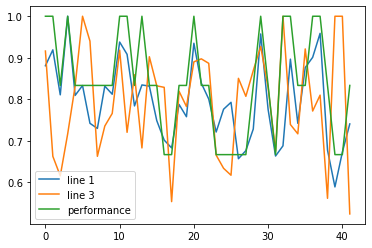

1.0 0.8807803468208093
1.0 0.9190751445086706
1.0 0.8106936416184971
1.0 1.0
0.8333333333333334 0.8092485549132948
1.0 0.833092485549133
0.8333333333333334 0.7420520231213873
0.8333333333333334 0.7297687861271677
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
1.0 0.9082369942196532
0.8333333333333334 0.7839595375722543
1.0 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
0.6666666666666666 0.7015895953757225
0.6666666666666666 0.6828034682080925
0.8333333333333334 0.7875722543352601
0.8333333333333334 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
0.8333333333333334 0.8005780346820809
0.6666666666666666 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.6666666666666666 0.7926300578034682
0.8333333333333334 0.6567919075144508
0.6666666666666666 0.6763005780346821
0.8333333333333334 0.7283236994219653
1.0 0.9573699421965318
0.8333333333333334 0.7752890173410405
0.66

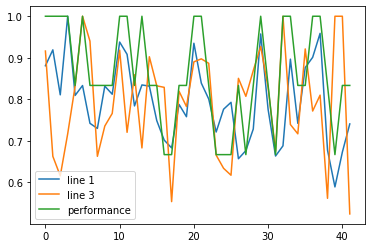

1.0 0.8807803468208093
1.0 0.9190751445086706
1.0 0.8106936416184971
1.0 1.0
0.8333333333333334 0.8092485549132948
1.0 0.833092485549133
0.8333333333333334 0.7420520231213873
0.8333333333333334 0.7297687861271677
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
1.0 0.9082369942196532
0.8333333333333334 0.7839595375722543
1.0 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
0.6666666666666666 0.7015895953757225
0.6666666666666666 0.6828034682080925
0.8333333333333334 0.7875722543352601
0.8333333333333334 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
0.8333333333333334 0.8005780346820809
0.8333333333333334 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.6666666666666666 0.7926300578034682
0.8333333333333334 0.6567919075144508
0.6666666666666666 0.6763005780346821
1.0 0.7283236994219653
1.0 0.9573699421965318
0.8333333333333334 0.7752890173410405
0.6666666666666666 

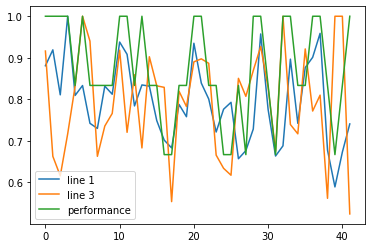

1.0 0.8807803468208093
1.0 0.9190751445086706
1.0 0.8106936416184971
1.0 1.0
0.8333333333333334 0.8092485549132948
1.0 0.833092485549133
0.8333333333333334 0.7420520231213873
0.8333333333333334 0.7297687861271677
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
1.0 0.9082369942196532
0.8333333333333334 0.7839595375722543
1.0 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
0.6666666666666666 0.7015895953757225
0.6666666666666666 0.6828034682080925
0.8333333333333334 0.7875722543352601
0.8333333333333334 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
0.8333333333333334 0.8005780346820809
0.8333333333333334 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.8333333333333334 0.7926300578034682
0.8333333333333334 0.6567919075144508
0.8333333333333334 0.6763005780346821
1.0 0.7283236994219653
1.0 0.9573699421965318
0.8333333333333334 0.7752890173410405
0.6666666666666666 

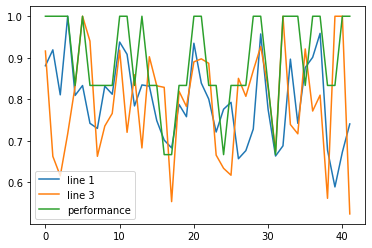

1.0 0.8807803468208093
1.0 0.9190751445086706
1.0 0.8106936416184971
1.0 1.0
0.8333333333333334 0.8092485549132948
1.0 0.833092485549133
0.8333333333333334 0.7420520231213873
0.8333333333333334 0.7297687861271677
1.0 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
1.0 0.9082369942196532
1.0 0.7839595375722543
1.0 0.8345375722543352
0.8333333333333334 0.8316473988439307
1.0 0.7485549132947977
0.6666666666666666 0.7015895953757225
0.6666666666666666 0.6828034682080925
0.8333333333333334 0.7875722543352601
1.0 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
1.0 0.8005780346820809
0.8333333333333334 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.8333333333333334 0.7926300578034682
0.8333333333333334 0.6567919075144508
0.8333333333333334 0.6763005780346821
1.0 0.7283236994219653
1.0 0.9573699421965318
1.0 0.7752890173410405
0.6666666666666666 0.6632947976878613
1.0 0.6878612716763006
1.0 0.8966763005780347
1.0 0.7420520231213873
0.

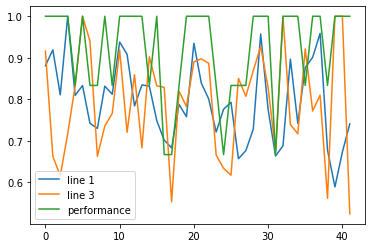

1.0 0.8807803468208093
1.0 0.9190751445086706
1.0 0.8106936416184971
1.0 1.0
1.0 0.8092485549132948
1.0 0.833092485549133
0.8333333333333334 0.7420520231213873
0.8333333333333334 0.7297687861271677
1.0 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
0.8333333333333334 0.9082369942196532
1.0 0.7839595375722543
0.6666666666666666 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
0.8333333333333334 0.7015895953757225
0.8333333333333334 0.6828034682080925
0.8333333333333334 0.7875722543352601
1.0 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
1.0 0.8005780346820809
0.8333333333333334 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.8333333333333334 0.7926300578034682
0.8333333333333334 0.6567919075144508
0.8333333333333334 0.6763005780346821
1.0 0.7283236994219653
1.0 0.9573699421965318
1.0 0.7752890173410405
0.6666666666666666 0.6632947976878613
1.0 0.6878612716763006
0.8333333333333334

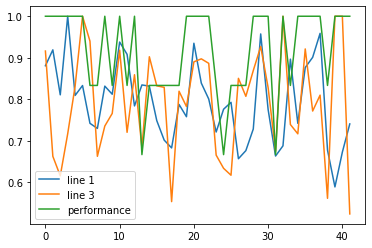

1.0 0.8807803468208093
0.8333333333333334 0.9190751445086706
1.0 0.8106936416184971
1.0 1.0
1.0 0.8092485549132948
1.0 0.833092485549133
0.8333333333333334 0.7420520231213873
0.8333333333333334 0.7297687861271677
1.0 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
0.8333333333333334 0.9082369942196532
1.0 0.7839595375722543
0.6666666666666666 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
1.0 0.7015895953757225
0.6666666666666666 0.6828034682080925
1.0 0.7875722543352601
1.0 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
1.0 0.8005780346820809
1.0 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.8333333333333334 0.7926300578034682
0.8333333333333334 0.6567919075144508
0.8333333333333334 0.6763005780346821
1.0 0.7283236994219653
1.0 0.9573699421965318
1.0 0.7752890173410405
0.6666666666666666 0.6632947976878613
1.0 0.6878612716763006
0.8333333333333334 0.8966763005780347
1.0 0.7420

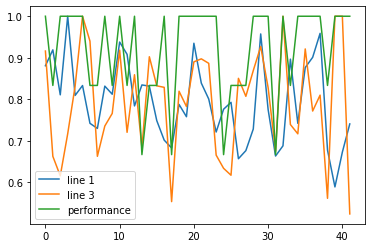

1.0 0.8807803468208093
0.8333333333333334 0.9190751445086706
1.0 0.8106936416184971
0.8333333333333334 1.0
0.8333333333333334 0.8092485549132948
1.0 0.833092485549133
1.0 0.7420520231213873
0.8333333333333334 0.7297687861271677
1.0 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
0.8333333333333334 0.9082369942196532
0.8333333333333334 0.7839595375722543
0.6666666666666666 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
1.0 0.7015895953757225
0.8333333333333334 0.6828034682080925
1.0 0.7875722543352601
1.0 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
1.0 0.8005780346820809
1.0 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.8333333333333334 0.7926300578034682
1.0 0.6567919075144508
0.8333333333333334 0.6763005780346821
1.0 0.7283236994219653
1.0 0.9573699421965318
1.0 0.7752890173410405
0.6666666666666666 0.6632947976878613
1.0 0.6878612716763006
0.8333333333333334 0.896676300578

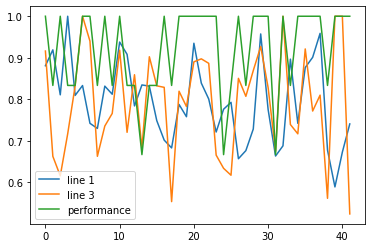

1.0 0.8807803468208093
0.8333333333333334 0.9190751445086706
1.0 0.8106936416184971
0.8333333333333334 1.0
0.8333333333333334 0.8092485549132948
1.0 0.833092485549133
1.0 0.7420520231213873
0.8333333333333334 0.7297687861271677
1.0 0.8316473988439307
0.8333333333333334 0.8121387283236994
1.0 0.9378612716763006
0.8333333333333334 0.9082369942196532
0.8333333333333334 0.7839595375722543
0.6666666666666666 0.8345375722543352
0.8333333333333334 0.8316473988439307
0.8333333333333334 0.7485549132947977
1.0 0.7015895953757225
0.8333333333333334 0.6828034682080925
1.0 0.7875722543352601
1.0 0.7579479768786127
1.0 0.934971098265896
1.0 0.8388728323699421
1.0 0.8005780346820809
1.0 0.7210982658959537
0.6666666666666666 0.7760115606936416
0.8333333333333334 0.7926300578034682
1.0 0.6567919075144508
0.8333333333333334 0.6763005780346821
1.0 0.7283236994219653
1.0 0.9573699421965318
1.0 0.7752890173410405
0.6666666666666666 0.6632947976878613
1.0 0.6878612716763006
0.8333333333333334 0.896676300578

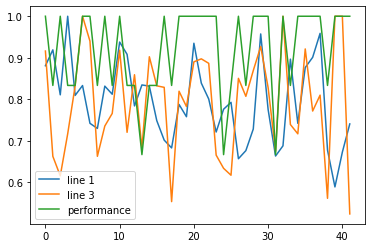

final accuracy in all weight p:  [0.8412698412698412, 0.8611111111111113, 0.8730158730158729, 0.8928571428571429, 0.9206349206349207, 0.9166666666666666, 0.9206349206349206, 0.9206349206349206, 0.9206349206349206]


In [6]:
# SVM
# late fusion
import sys
from matplotlib import pyplot as plt
from sklearn.svm import SVC
def getmax(L):
    a = 0
    b = 0
    c = 0
    for i in L:
        if i == 0:
            a += 1
        elif i == 1:
            b += 1
        else:
            c += 1
    if a > b >= c or a > c >= b:
        return 0
    if b > a >= c or b > c >= a:
        return 1
    if c > a >= b or c > b >= a:
        return 2
    return 0

import oselm as elm
train_len = 2010
test_len = 1384
train_index = [235, 233, 206, 238, 185, 195, 237, 216, 265]
test_index = [237, 235, 233, 235, 238, 206]

weight_parameter = [0.1,0.2,0.3,0.4, 0.5, 0.6,0.7,0.8,0.9]

weighted_acc = []
for weight in weight_parameter:
    acc = []
    acc1_out = []
    acc2_out = []
    acc3_out = []
    result = []
    true_y = []
    pred_y = []
    for i in range(42):
        x_train_feature_de = deconv.predict(xtrain_CNN[i*train_len:(i+1)*train_len])
        x_test_feature_de = deconv.predict(xtest_CNN[i*test_len:(i+1)*test_len])
        Train_y = trainy[i*train_len:(i+1)*train_len]
        Test_y = testy[i*test_len:(i+1)*test_len]
        Train_y = Train_y.reshape(Train_y.shape[0],1)
        Test_y = Test_y.reshape(Test_y.shape[0],1)
        train_yym = feature_set[i][:, :x_train_feature_de.shape[0]]
        test_yym = feature_set[i][:, x_train_feature_de.shape[0]:]


        Training1 = np.concatenate((Train_y, x_train_feature_de), axis = 1)
        Testing1 = np.concatenate((Test_y, x_test_feature_de), axis=1)
        Training3 = np.concatenate((Train_y, train_yym.T), axis = 1)
        Testing3 = np.concatenate((Test_y, test_yym.T), axis=1)

        sample_acc = []
        acc1 = []
        yacc = []
        set_pred = []
        set_true = []
        for ccc in range(1, 20):
            c2 = ccc-10
            C2 = 2 ** c2
            model1 = SVC(gamma='auto', kernel='sigmoid', C=C2)
            model3 = elm.ELM(1, 1, 'sig', 1, C2)
            Train_y = Train_y.reshape((Train_y.shape[0],))
            Test_y = Test_y.reshape((Test_y.shape[0],))
            model1.fit(x_train_feature_de, Train_y)
            #model3.fit(train_yym.T, Train_y)
            #print(x_train_feature_de.shape,x_train_feature_de2.shape,Train_y.shape,  train_yym.shape )
            Testing_acc = model1.score(x_test_feature_de, Test_y)
            #Testing_acc3 = model3.score(test_yym.T, Test_y)
            le = Test_y
            la = model1.predict(x_test_feature_de)
            _, Testing3_acc, le3, la3 = model3.train(Training3, Testing3)

            sample = 0
            idx_expected = []
            idx_actural = []
            for j in range(len(test_index)):
                A = le[sample:test_index[j] + sample]
                idx_expected.append(getmax(A))

                B = la[sample:test_index[j] + sample]
                B3 = la3[sample:test_index[j] + sample]
                B_all = np.concatenate((B, B3))

                for weight_add in range(int((1-weight)*10)-1):
                    B_all = np.concatenate((B_all, B))

                for weight_add in range(int(weight*10)-1):
                    B_all = np.concatenate((B_all, B3))

                idx_actural.append(getmax(B_all))
                sample += test_index[j]

            idx_expected = np.array(idx_expected)
            idx_actural = np.array(idx_actural)
            set_true.append(idx_expected)
            set_pred.append(idx_actural)
            #print('debug: le, la',idx_expected, idx_actural)
            accuracy = np.sum(idx_expected - idx_actural == 0) / 6
            #print('debug: acc',accuracy)
            acc1.append(accuracy)
            sample_acc.append(Testing_acc)
            yacc.append(accuracy)
        acc.append(np.max(yacc))
        true_y.append(set_true[np.argmax(yacc)])
        pred_y.append(set_pred[np.argmax(yacc)])
        print(np.max(yacc), Testing_acc)
        acc1_out.append(Testing_acc)
        #acc2_out.append(Testing2_acc)
        acc3_out.append(Testing3_acc)
        result.append(np.max(yacc))
    total_test_accuarcy = np.mean(acc)
    print("total_test_accuarcy", total_test_accuarcy)
    weighted_acc.append(total_test_accuarcy)
    # plot lines
    plt.plot(acc1_out, label = "line 1")
    #plt.plot(acc2_out, label = "line 2")
    plt.plot(acc3_out, label = "line 3")
    plt.plot(result, label = "performance")

    plt.legend()
    plt.show()

print("final accuracy in all weight p: ", weighted_acc)